In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn

sys.path.append('./PerceptualSimilarity')
from PerceptualSimilarity import models as LPIPS_models

In [4]:
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    os.remove("tmp")
    return np.argmax(memory_available)

freer_gpu = get_freer_gpu()
torch.cuda.set_device(int(freer_gpu))
torch.cuda.empty_cache()

print("GPUs:"+str(torch.cuda.device_count()))
print("Selected GPU:"+str(freer_gpu + 1))
print("Available memory:" + str(gpu_mem_get_free_no_cache()) + "MB")

GPUs:2
Selected GPU:1
Available memory:11008MB


## Create dataset

Zatím jen pro otestování trénování vezmu DIV2K a sám si ho zmenším a uložím ve špatné JPEG kvalitě. O něco se postará bluring v Learner class, ale cílem je ještě přidat šum a nějaký uvěřitelný blur a následně to porovnat s RealSR datasetem. Pokud tam bude vidět zlepšení, zkusím se posunout k vytváření trénovacího setu uměle pomocí NN.

In [5]:
path_dataset = Path('datasets/DIV2K')
path_hr = path_dataset/'images'

def get_lr_path(img_size): return path_dataset/f"small-{img_size}"
path_lr_64, path_lr_128, path_lr_256 = get_lr_path(64), get_lr_path(128), get_lr_path(256)

scale = 2

proj_id = 'base_model'

gen_name = proj_id + '_gen'
pre_gen_name = gen_name + '_0'
crit_name = proj_id + '_crit'

name_gen = proj_id + '_image_gen'
path_gen = path_dataset/name_gen

TENSORBOARD_PATH = Path('data/tensorboard/' + proj_id)


pct_start = 1e-8

In [6]:
il = ImageImageList.from_folder(path_hr)
il

ImageImageList (900 items)
Image (3, 1344, 2040),Image (3, 1368, 2040),Image (3, 1536, 2040),Image (3, 1356, 2040),Image (3, 1356, 2040)
Path: datasets/DIV2K/images

In [56]:
from PIL import Image as PILImage

# dataset for resizing whole images
class crappifier(object):
    def __init__(self, path_lr, path_hr, size):
        self.path_lr = path_lr
        self.path_hr = path_hr
        self.size = size

    def __call__(self, fn, i):
        dest = self.path_lr / fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PILImage.open(fn)
        targ_sz = resize_to(img, self.size, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w, h = img.size
        q = random.randint(10, 70)
        img.save(dest, quality=q)
        
#dataset for resizing patches
class crapifier_original(object):
    def __init__(self, path_lr, path_hr, size):
        self.path_lr = path_lr
        self.path_hr = path_hr

    def __call__(self, fn, i):
        dest = self.path_lr / fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PILImage.open(fn)
        targ_sz = tuple(s//scale for s in img.size)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w, h = img.size
        q = random.randint(10, 70)
        img.save(dest, quality=q)
        

Pre-resize and pre-deform images fixed LR size for faster data handling. I'll need a few different sizes, because for a fast model training it's useful to gradually increase image size.

I'll use crappifier class for transforming clear HR images into corresponding corrupted LR ones.

In [66]:
# create smaller image sets the first time this nb is run
def generate_lr(size):
    p = path_dataset/f"small-{size}"
    if not p.exists(): 
        print(f"Resizing images to {size}px into {p}")
        parallel(crappifier(path_lr=p, path_hr=path_hr, size=size), il.items)        
    return p

# create smaller image sets for patches the first time this nb is run
def generate_patch_lr():
    p = path_dataset/f"downsc-{scale}x"
    if not p.exists(): 
        print(f"Downsampling images 2x into {p}")
        parallel(crapifier_original(path_lr=p, path_hr=path_hr, size=size), il.items)        
    return p


sets = [64, 128, 256]
lr_paths = []
for size in sets:
    lr_paths += [generate_lr(size)]
    
lr_paths += [generate_patch_lr()]
lr_paths

Resizing images to 64px into datasets/DIV2K/small-64


Resizing images to 128px into datasets/DIV2K/small-128


Resizing images to 256px into datasets/DIV2K/small-256


[PosixPath('datasets/DIV2K/small-64'),
 PosixPath('datasets/DIV2K/small-128'),
 PosixPath('datasets/DIV2K/small-256'),
 PosixPath('datasets/DIV2K/downsc-2x')]

Functions for obtaining DataBunch (which is serving training batches), including a dummy one for fast testing.

In [67]:
"""Obtain DataBunch for given target image size and batch size"""
def get_data(y_size,
             bs,
             keep_pct: float = 1.0,
             xtra_tfms=[],
             random_seed: int = None,
             stats: tuple = imagenet_stats) -> ImageDataBunch:
    
    lr_path = generate_lr(y_size//scale)
    
    src = (
        ImageImageList.from_folder(lr_path) \
                        .use_partial_data(sample_pct=keep_pct, seed=random_seed) \
                        .split_by_folder(train="Train", valid="Validation")
    )
    
    data = (
        src.label_from_func(lambda x: path_hr/x.parent.parts[-1]/x.name)
           .transform(
               get_transforms(
                   max_zoom=1.2, max_lighting=0.5, max_warp=0.25, xtra_tfms=xtra_tfms
               ), 
               size=y_size, 
               tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats, do_y=True)
    )
    doc(src.transform)
    data.c = 3
    return data

"""Very small dataset for testing purposes"""
def get_dummy_data(y_size=128, bs=1) -> ImageDataBunch:
    path = Path('./dummy/')
    return get_data(
        y_size=y_size, bs=bs, keep_pct=0.04
    )

Show some example inputs and targets in task

$ {LR}_{256px} -> {HR}_{512px} $

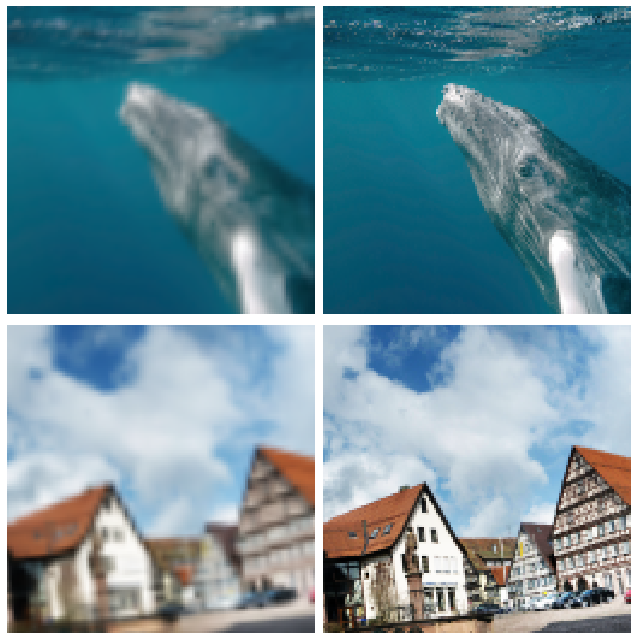

In [68]:
# I need data further for getting denormalizations, don't remove
data = get_data(128, 8)
data.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(9,9))

## Feature loss

In [11]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [12]:
base_loss = F.l1_loss

In [13]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [14]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [15]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Metrics

In addition to metrics traditionally used in image processing, PSNR and SSIM we'll used perception metrics, which are using activations from a pretrained classification AlexNet model, which is 

### Traditional metrics
Metrics traditionally used for image restoration benchmarking are PSNR and SSIM. They not always show the similarity as perceived by human observer, but are easily measurable and suitable for comparing different algorithms on a task with no geometric deformation.

In [33]:
from fastai.metrics import psnr

"""Decorator dnormalizing image by pushing it to [0,1] range"""
def denormalize(func):
    def _denormalized(pred, targ):
        pred = data.denorm(pred).clamp(min=0,max=1)
        targ = data.denorm(targ).clamp(min=0,max=1)
        return func(pred, targ)
    _denormalized.__name__ = func.__name__
    return _denormalized

"""Peak signal to noise ratio"""
PSNR = denormalize(psnr)


In [34]:
from ssim import ssim

SSIM = denormalize(ssim)

### LPIPS (Learned Perceptual Image Patch Similarity) metric

Paper [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric](https://arxiv.org/abs/1801.03924). In principle it's similar to our Feature Loss, taking activations in this case from Alex Net and fine tuning according to a study with human participants on Amazon Mechanical Turk. There is adden another fully connected layer trying to predict the prefered image among two with different defformations. The activations from this layer are also used.

This metric was used in recent image restoration competitions such as the recent NTIRE 2020 Challenge on Real-World Image Super-Resolution.



In [35]:
_LPIPS_dist = LPIPS_models.PerceptualLoss(model='net-lin', net='alex')

@denormalize
def LPIPS(pred, targ): 
    result = _LPIPS_dist(pred, targ)
    result = torch.mean(result).squeeze()
    return result

Setting up Perceptual loss...
Loading model from: /home/luslad/thesis/PerceptualSimilarity/models/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [36]:
metrics = [AverageMetric(PSNR), AverageMetric(SSIM), AverageMetric(LPIPS)]

In [37]:
arch = models.resnet34

In [38]:
bs,size=32,128

In [39]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=metrics, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

## Train

In [40]:
# testing metrics on dummy data
dummy_data = get_dummy_data()
learn.data = dummy_data
learn.fit_one_cycle(1, 1e-3, pct_start=0.9)

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,5.173145,4.822405,18.010044,0.494501,0.311417,0.450269,0.319667,0.442083,0.174058,1.213104,1.911547,0.311676,00:05


### 32px → 64px

In [44]:
data = get_data(64,88)
learn.data = data

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [50]:
lr = 1e-3

In [51]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,PSNR,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,4.896109,4.211158,19.728786,7.053491,0.326698,0.301596,0.403159,0.185146,0.997422,1.528857,0.468280,00:24
1,4.197302,3.494689,21.333237,8.707217,0.251364,0.252351,0.340881,0.164170,0.763985,1.279815,0.442123,00:23
2,3.753767,3.176254,21.452074,8.867272,0.255345,0.232527,0.311879,0.157833,0.648805,1.134807,0.435056,00:24
3,3.507424,3.044196,21.854477,9.231980,0.232210,0.228136,0.302332,0.153552,0.622573,1.082976,0.422419,00:23
4,3.347740,3.050537,21.305225,8.678499,0.260105,0.227664,0.298473,0.152436,0.613704,1.078388,0.419767,00:23
5,3.283569,2.937260,21.515936,8.961596,0.249453,0.222118,0.290673,0.149669,0.583868,1.024694,0.416784,00:24
6,3.315336,3.198236,21.710480,9.059978,0.251447,0.229888,0.311826,0.155165,0.689438,1.136246,0.424227,00:23
7,3.360889,3.107071,22.101957,9.519812,0.229781,0.219634,0.298097,0.151778,0.697346,1.090845,0.419590,00:23
8,3.340820,3.040859,22.128281,9.576193,0.228695,0.216796,0.292866,0.150601,0.671253,1.062914,0.417734,00:23
9,3.279116,2.929046,22.470825,9.879371,0.207877,0.211523,0.286115,0.147494,0.637861,1.027618,0.410559,00:24


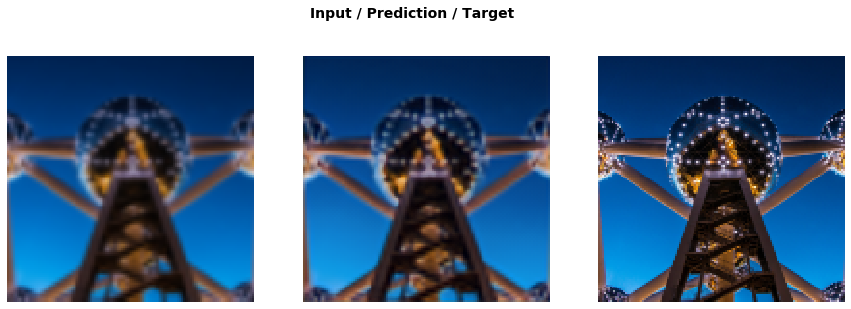

In [52]:
do_fit('1a', slice(lr*10))

In [33]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


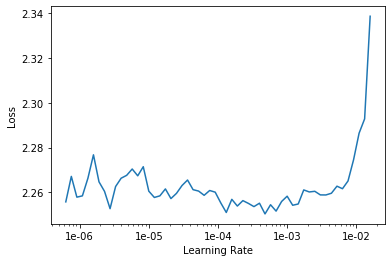

In [34]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,PSNR,LPIPS,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.296512,2.037982,23.656742,0.058071,0.172241,0.150319,0.197561,0.103905,0.401631,0.712244,0.300081,00:25
1,2.288472,2.023396,23.646229,0.058536,0.168651,0.149607,0.196462,0.103710,0.399816,0.705551,0.299598,00:24
2,2.272114,2.001687,23.627411,0.056286,0.168640,0.148658,0.194568,0.103084,0.395072,0.693455,0.298212,00:23
3,2.263687,1.981940,23.630903,0.054329,0.168283,0.147808,0.192962,0.102315,0.389794,0.685027,0.295752,00:22
4,2.255560,1.972337,23.587132,0.052759,0.169402,0.147493,0.192173,0.101937,0.386466,0.680443,0.294424,00:23
5,2.257285,1.968457,23.589096,0.053519,0.169341,0.147479,0.191860,0.101660,0.385159,0.678597,0.294362,00:26
6,2.243260,1.944681,23.592642,0.052100,0.169317,0.146715,0.190510,0.100814,0.376626,0.668899,0.291801,00:25
7,2.228621,1.938378,23.607021,0.052826,0.168975,0.146535,0.190062,0.100537,0.373129,0.668516,0.290622,00:23
8,2.211515,1.927666,23.635674,0.053803,0.167721,0.146487,0.189815,0.100198,0.368422,0.665934,0.289089,00:24
9,2.190954,1.902711,23.617523,0.051023,0.167724,0.145465,0.187884,0.099078,0.361401,0.654717,0.286442,00:25


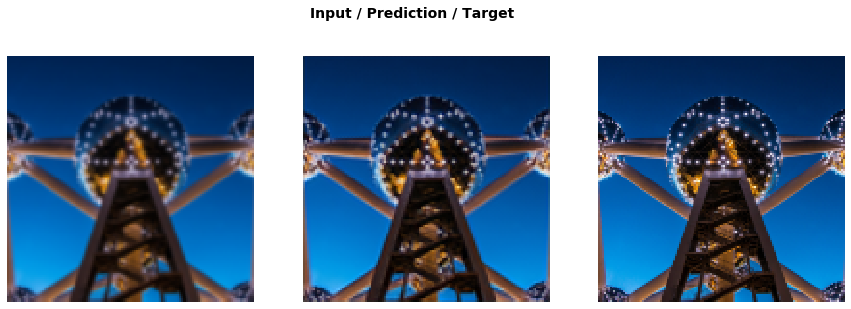

In [55]:
do_fit('1b', slice(1e-5,lr))

In [72]:
data = get_data(12,size*2)

In [73]:
learn.data = data
learn.freeze()
gc.collect()

211

In [74]:
learn.load('1b');

epoch,train_loss,valid_loss,PSNR,LPIPS,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.314289,2.212972,22.700701,0.261064,0.196708,0.210724,0.262799,0.126600,0.559019,0.607740,0.249383,00:29
1,2.289917,2.187977,22.737556,0.255447,0.196531,0.209788,0.260844,0.125336,0.546807,0.601324,0.247348,00:31
2,2.274129,2.173630,22.790638,0.247432,0.195728,0.210009,0.259752,0.124320,0.535946,0.602385,0.245492,00:31
3,2.262390,2.123142,22.809624,0.235455,0.194580,0.209140,0.256281,0.122713,0.510415,0.586939,0.243074,00:31
4,2.247503,2.131993,22.789011,0.222583,0.199818,0.212582,0.257932,0.123170,0.499170,0.596044,0.243278,00:31
5,2.239545,2.170525,22.804815,0.216019,0.199002,0.212589,0.261045,0.124058,0.499442,0.630587,0.243801,00:30
6,2.216355,2.117086,22.836203,0.213108,0.196200,0.212000,0.257152,0.123403,0.488122,0.597331,0.242878,00:31
7,2.184572,2.142411,22.704075,0.206972,0.203781,0.213154,0.258759,0.124333,0.480808,0.618287,0.243289,00:31
8,2.188565,2.137102,22.737646,0.207311,0.205099,0.213816,0.258824,0.124518,0.480212,0.611678,0.242956,00:31
9,2.165380,2.074598,22.837587,0.205009,0.193545,0.211390,0.254071,0.123209,0.474251,0.576510,0.241623,00:31


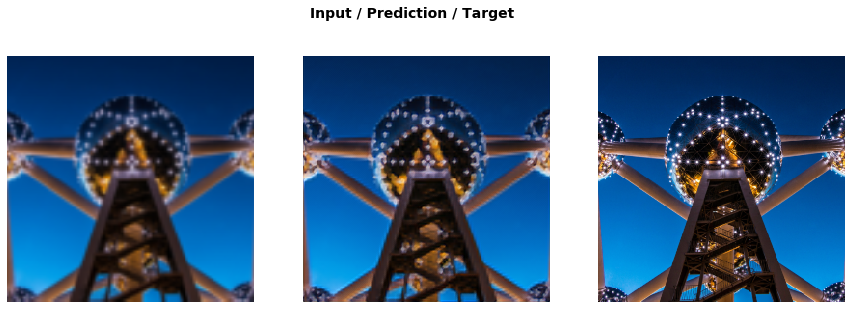

In [75]:
do_fit('2a')

In [76]:
learn.unfreeze()

epoch,train_loss,valid_loss,PSNR,LPIPS,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.153159,2.064344,22.863192,0.204105,0.191841,0.211359,0.253794,0.123277,0.470112,0.572630,0.241331,00:32
1,2.125877,2.059388,22.868015,0.203747,0.191630,0.211080,0.253183,0.123091,0.468648,0.570984,0.240771,00:31
2,2.124553,2.060946,22.866869,0.202228,0.192010,0.211343,0.253422,0.123376,0.465927,0.573933,0.240934,00:31
3,2.123690,2.059894,22.878208,0.201128,0.192677,0.211997,0.253637,0.123284,0.466265,0.570741,0.241293,00:32
4,2.125964,2.046692,22.892387,0.201179,0.190612,0.211048,0.252666,0.123193,0.461211,0.567223,0.240740,00:32
5,2.113211,2.054421,22.888964,0.200570,0.190919,0.211135,0.252713,0.123185,0.462399,0.573428,0.240642,00:33
6,2.115916,2.049256,22.893406,0.199974,0.190697,0.211217,0.252549,0.123281,0.461861,0.568712,0.240940,00:32
7,2.115421,2.044190,22.900307,0.200196,0.190425,0.211049,0.252261,0.123074,0.460400,0.566387,0.240594,00:32
8,2.117345,2.045974,22.898218,0.200064,0.190517,0.211110,0.252303,0.123073,0.460938,0.567404,0.240628,00:32
9,2.128477,2.045814,22.898685,0.200030,0.190474,0.211096,0.252282,0.123082,0.460888,0.567360,0.240630,00:32


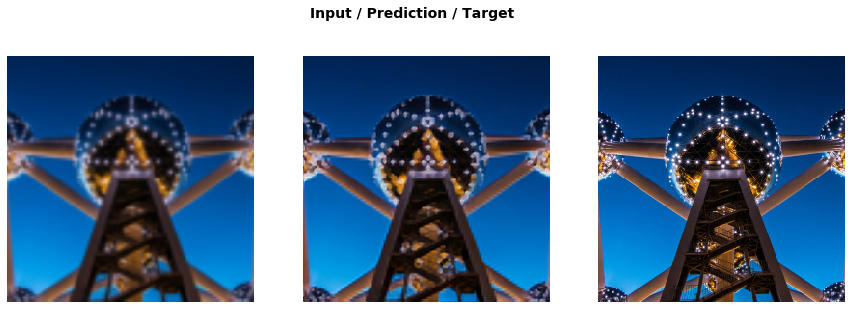

In [77]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

In [78]:
data = get_data(4,size*4)

In [79]:
learn.data = data
learn.freeze()
gc.collect()

12982

In [80]:
learn.load('2b');

epoch,train_loss,valid_loss,PSNR,LPIPS,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.179115,2.125313,21.660664,0.405718,0.225806,0.259994,0.281812,0.115243,0.617177,0.472231,0.153050,01:42
1,2.206312,2.125138,21.647243,0.397231,0.227789,0.261680,0.282730,0.115010,0.606856,0.478351,0.152722,01:39
2,2.081478,2.063511,21.609697,0.356870,0.231488,0.272223,0.283753,0.111057,0.536671,0.473365,0.154954,01:40
3,1.985437,2.043318,21.600637,0.340343,0.235018,0.272842,0.285756,0.111539,0.511961,0.471161,0.155039,01:40
4,1.959022,2.019930,21.580450,0.334461,0.240327,0.271108,0.285249,0.112230,0.491932,0.464847,0.154239,01:40
5,1.916453,2.003940,21.729319,0.334514,0.231228,0.269704,0.285569,0.112279,0.482958,0.469025,0.153176,01:40
6,1.934349,1.983240,21.677052,0.328288,0.233965,0.273260,0.288627,0.112683,0.474054,0.447544,0.153107,01:40
7,1.933522,1.970686,21.666353,0.322823,0.231839,0.271191,0.284725,0.113940,0.466542,0.450427,0.152022,01:41
8,1.909236,1.948186,21.798847,0.311470,0.225964,0.271272,0.283893,0.113579,0.448178,0.453632,0.151667,01:40
9,1.857269,1.880933,21.844444,0.307631,0.221010,0.267085,0.279438,0.113350,0.430515,0.418874,0.150660,01:40


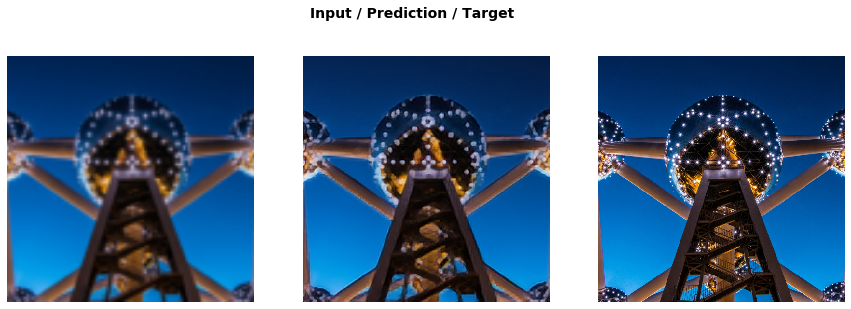

In [81]:
do_fit('3a')

In [82]:
learn.unfreeze()

epoch,train_loss,valid_loss,PSNR,LPIPS,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


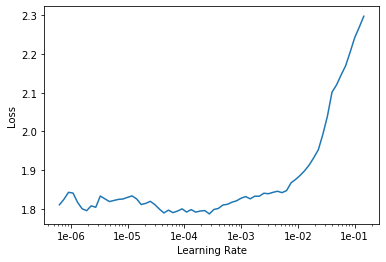

In [83]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,PSNR,LPIPS,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.843376,1.866970,21.846617,0.306650,0.220626,0.266295,0.278105,0.113480,0.428242,0.409976,0.150246,01:43
1,1.807683,1.856562,21.845057,0.302905,0.220928,0.265583,0.276856,0.113488,0.424470,0.405485,0.149752,01:44
2,1.806460,1.867421,21.746271,0.303127,0.224668,0.266789,0.278166,0.113569,0.426019,0.408589,0.149621,01:44
3,1.812450,1.843974,21.876995,0.302043,0.218432,0.263581,0.275285,0.112818,0.421413,0.403649,0.148797,01:44
4,1.795724,1.837829,21.804531,0.298276,0.220989,0.264600,0.275083,0.112715,0.416256,0.399280,0.148907,01:44
5,1.793153,1.836967,21.859045,0.297707,0.219089,0.263411,0.274733,0.112728,0.415462,0.403121,0.148422,01:43
6,1.767350,1.822598,21.822721,0.292979,0.219803,0.263248,0.274188,0.113081,0.410916,0.392977,0.148386,01:43
7,1.782448,1.819785,21.822763,0.294140,0.219854,0.263036,0.273617,0.112234,0.409826,0.392896,0.148322,01:43
8,1.794464,1.821523,21.799200,0.293413,0.220388,0.264211,0.274549,0.112948,0.408877,0.392131,0.148419,01:43
9,1.762727,1.817685,21.797232,0.292691,0.220570,0.263541,0.273647,0.112619,0.408313,0.390566,0.148429,01:43


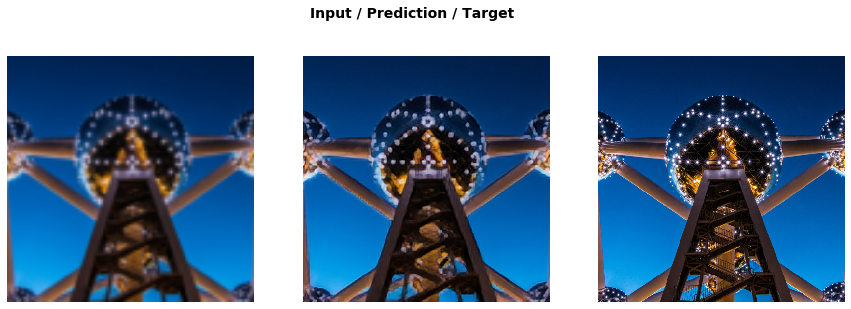

In [84]:
do_fit('3b', slice(1e-6,1e-4), pct_start=0.3)

## Test (simple)

Tohle nebude úplně dobře fungovat, protože jsem si neuvědomil, že se zvětšením target image musím zvětšit i zdrojový LR image. Takhle se bere jako input 96px obrázek, i když chci output 512px. To odpovídá vlastně 5.33x superresolution.

In [85]:
learn = None
gc.collect();

In [86]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

using size=(1280, 1600), have 9719MB of GPU RAM free


In [88]:
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=metrics, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.parent.parts[-1]/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [ ]:
learn.load('3b');

In [ ]:
learn.data = data_mr

In [ ]:
filename = data_mr.valid_ds.x.items[0]; filename

In [ ]:
def get_orig(path_lr):
    return path_hr/path_lr.parent.parts[-1]/path_lr.name
img_orig = open_image(get_orig(filename)); img_orig.shape

In [ ]:
img = open_image(filename); img.shape

In [ ]:
p,img_hr,b = learn.predict(img)

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
show_image(img_hr, figsize=(18,15))

In [ ]:
show_image(img_orig, figsize=(18,15))